In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ------------------------
# Depth-2 Tree Definition
# ------------------------

class Depth2Tree:
    def __init__(self):
        self.feature1 = None
        self.threshold1 = None
        self.feature2_left = None
        self.threshold2_left = None
        self.feature2_right = None
        self.threshold2_right = None
        self.values = {}

    def fit(self, X, grad, max_features=5, max_thresholds=5):
        m, n = X.shape
        best_loss = float('inf')
        feature_indices = np.random.choice(n, size=min(max_features, n), replace=False)

        for f1 in feature_indices:
            col1 = X[:, f1]
            thresholds1 = np.unique(np.percentile(col1, np.linspace(0, 100, max_thresholds)))
            for t1 in thresholds1:
                left1 = col1 <= t1
                right1 = ~left1
                if np.sum(left1) < 5 or np.sum(right1) < 5:
                    continue

                for f2l in feature_indices:
                    col2l = X[:, f2l]
                    thresholds2l = np.unique(np.percentile(col2l[left1], np.linspace(0, 100, max_thresholds))) if np.any(left1) else [0]
                    for t2l in thresholds2l:
                        mask_ll = left1 & (col2l <= t2l)
                        mask_lr = left1 & (col2l > t2l)
                        pred_ll = grad[mask_ll].mean() if mask_ll.any() else 0
                        pred_lr = grad[mask_lr].mean() if mask_lr.any() else 0

                        for f2r in feature_indices:
                            col2r = X[:, f2r]
                            thresholds2r = np.unique(np.percentile(col2r[right1], np.linspace(0, 100, max_thresholds))) if np.any(right1) else [0]
                            for t2r in thresholds2r:
                                mask_rl = right1 & (col2r <= t2r)
                                mask_rr = right1 & (col2r > t2r)
                                pred_rl = grad[mask_rl].mean() if mask_rl.any() else 0
                                pred_rr = grad[mask_rr].mean() if mask_rr.any() else 0

                                loss = (
                                    np.sum((grad[mask_ll] - pred_ll) ** 2) +
                                    np.sum((grad[mask_lr] - pred_lr) ** 2) +
                                    np.sum((grad[mask_rl] - pred_rl) ** 2) +
                                    np.sum((grad[mask_rr] - pred_rr) ** 2)
                                )

                                if loss < best_loss:
                                    best_loss = loss
                                    self.feature1 = f1
                                    self.threshold1 = t1
                                    self.feature2_left = f2l
                                    self.threshold2_left = t2l
                                    self.feature2_right = f2r
                                    self.threshold2_right = t2r
                                    self.values = {
                                        'll': pred_ll,
                                        'lr': pred_lr,
                                        'rl': pred_rl,
                                        'rr': pred_rr
                                    }

    def predict(self, X):
        preds = []
        for x in X:
            if x[self.feature1] <= self.threshold1:
                if x[self.feature2_left] <= self.threshold2_left:
                    preds.append(self.values['ll'])
                else:
                    preds.append(self.values['lr'])
            else:
                if x[self.feature2_right] <= self.threshold2_right:
                    preds.append(self.values['rl'])
                else:
                    preds.append(self.values['rr'])
        return np.array(preds)

# ------------------------
# XGBoost-like Model
# ------------------------

class XGBoostLike:
    def __init__(self, n_estimators=10, learning_rate=0.05):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.trees = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        m = len(y)
        y_pred = np.zeros(m)
        for _ in tqdm(range(self.n_estimators), desc="Training XGBoost-like model"):
            prob = self.sigmoid(y_pred)
            grad = y - prob
            tree = Depth2Tree()
            tree.fit(X, grad)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# ------------------------
# Load and Preprocess Data
# ------------------------

print("Loading data...")
train_df = pd.read_csv('/content/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('/content/customer_churn_dataset-testing-master.csv')
train_df = train_df.dropna()

column_mapping = {
    'CustomerID': 'CustomerID',
    'Age': 'Age',
    'Gender': 'Gender',
    'Tenure': 'Tenure',
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction',
    'Churn': 'Churn'
}
train_df = train_df.rename(columns=column_mapping)
test_df = test_df.rename(columns={
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction'
})

# Encode categorical columns
categorical_cols = ['Gender', 'Subscription', 'Contract_Length']
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Match columns
train_feature_columns = [col for col in train_encoded.columns if col != 'Churn']
for col in train_feature_columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
test_columns_to_use = [col for col in test_encoded.columns if col in train_feature_columns or col == 'Churn']
test_encoded = test_encoded[test_columns_to_use]

# Drop ID columns
train_encoded = train_encoded.drop('CustomerID', axis=1)
test_encoded = test_encoded.drop('CustomerID', axis=1)

# Extract features/targets
X_train = train_encoded.drop('Churn', axis=1)
y_train = train_encoded['Churn'].values

if 'Churn' in test_encoded.columns:
    X_test = test_encoded.drop('Churn', axis=1)
    y_test = test_encoded['Churn'].values
else:
    X_test = test_encoded
    y_test = None

print("Standardizing...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------
# Train and Evaluate
# ------------------------

print("Training model...")
model = XGBoostLike(n_estimators=10, learning_rate=0.1)
model.fit(X_train_scaled, y_train)

if y_test is not None:
    y_pred = model.predict(X_test_scaled)

    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Recall:   {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
else:
    print("No ground truth labels available in test data to evaluate.")


Loading data...
Standardizing...
Training model...


Training XGBoost-like model: 100%|██████████| 10/10 [09:25<00:00, 56.55s/it]



Accuracy: 0.5702
Recall:   0.5702
F1 Score: 0.4922


Loading datasets...
Training data shape after removing missing values: (440832, 12)
Aligning column names...
Preprocessing data...

Training features shape: (440832, 12)
Training target shape: (440832,)
Testing features shape: (64374, 12)
Testing target shape: (64374,)
Standardizing features...
Saving the scaler to scaler.pkl...
Scaler saved successfully!
Training SVM model efficiently...


100%|██████████| 500/500 [00:05<00:00, 84.21it/s] 


Training complete!
Saving the trained model to svm_efficient_model.pkl...
Model saved successfully!
Making predictions...

Training Set Evaluation:
Accuracy: 0.8960
Recall: 0.8668
F1 Score: 0.9043

Test Set Evaluation:
Accuracy: 0.5835
Recall: 0.9862
F1 Score: 0.6916


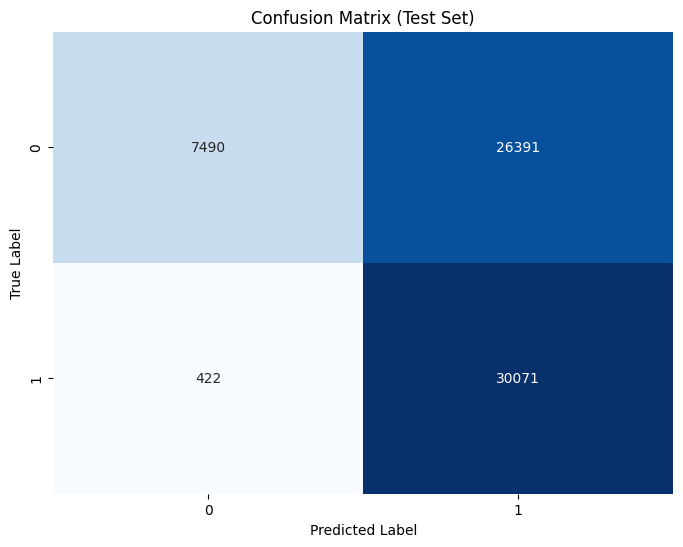


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.22      0.36     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.53     64374
weighted avg       0.75      0.58      0.52     64374



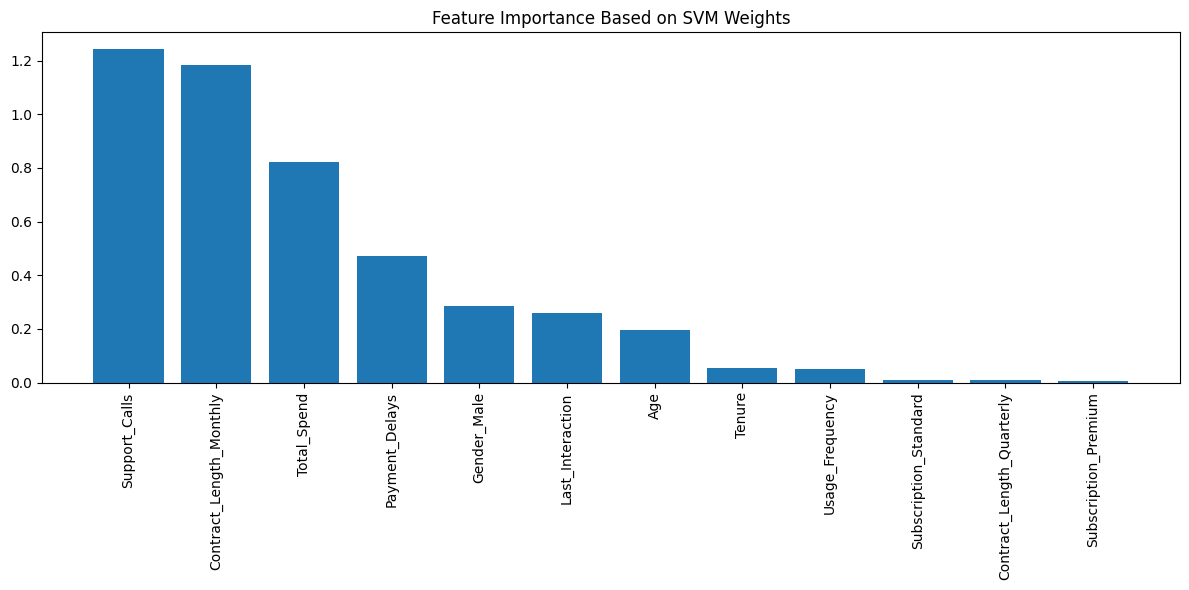

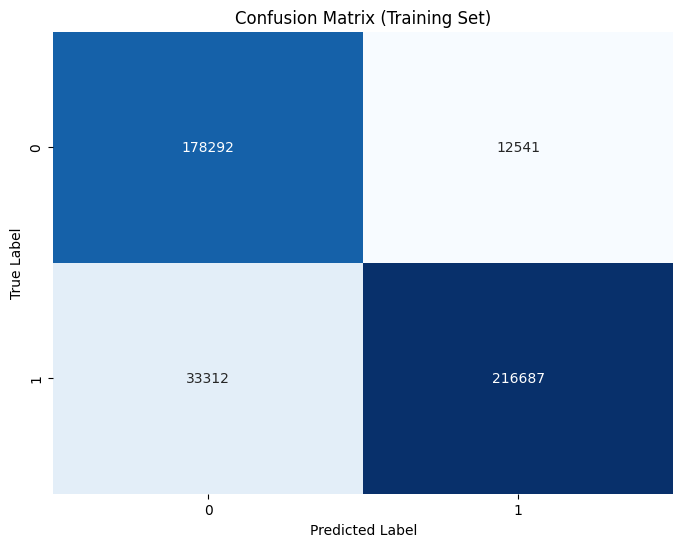


Customer Profile Comparison (Churn vs. Non-Churn):
                  Churn_Mean  Non_Churn_Mean  Difference
Age                41.747263       36.262973    5.484290
Tenure             30.473598       32.281754   -1.808156
Usage_Frequency    15.461658       16.260552   -0.798895
Support_Calls       5.144861        1.586418    3.558442
Payment_Delays     15.217729       10.015500    5.202228
Total_Spend       541.285528      749.953111 -208.667584
Last_Interaction   15.604546       13.008804    2.595743


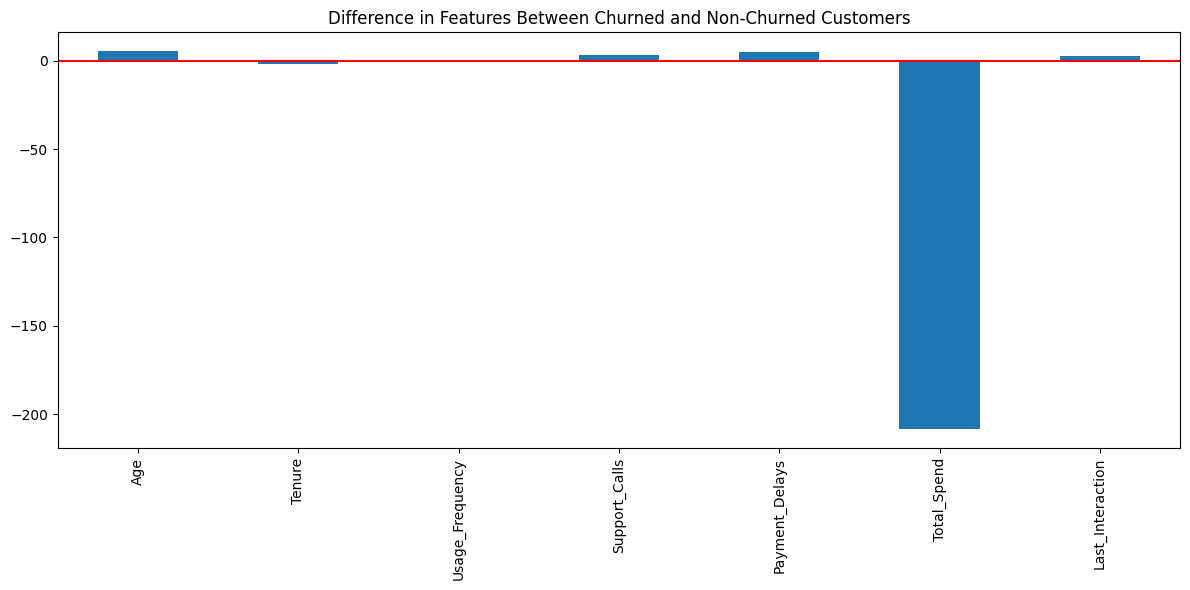

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm  # For progress bar
import pickle

# Define a more efficient SVM implementation
class SVM_Efficient:
    def __init__(self, learning_rate=0.02, lambda_param=0.005, n_iters=500, batch_size=32):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.w = None
        self.b = None

    def fit(self, X, y):
        # Convert y values to -1 and 1 (SVM convention)
        y_ = np.where(y <= 0, -1, 1)

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        # Use mini-batch gradient descent for efficiency
        print("Training SVM model efficiently...")
        for _ in tqdm(range(self.n_iters)):
            # Create random batch indices
            batch_indices = np.random.choice(n_samples, min(self.batch_size, n_samples), replace=False)
            X_batch = X[batch_indices]
            y_batch = y_[batch_indices]

            # Compute gradients on batch
            for idx, x_i in enumerate(X_batch):
                condition = y_batch[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_batch[idx]))
                    self.b -= self.lr * y_batch[idx]

            # Decrease learning rate slightly each iteration (learning rate decay)
            self.lr = self.lr * 0.99

    def predict(self, X):
        # Calculate decision function
        decision_function = np.dot(X, self.w) - self.b

        # Convert to binary predictions (0 or 1)
        return np.where(decision_function <= 0, 0, 1)

# Load the train and test datasets
print("Loading datasets...")
train_df = pd.read_csv('/content/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('/content/customer_churn_dataset-testing-master.csv')

# Handle missing values in training data
train_df = train_df.dropna()
print(f"Training data shape after removing missing values: {train_df.shape}")

# Ensure column names match between datasets
# Rename columns based on test dataset format
print("Aligning column names...")
column_mapping = {
    'CustomerID': 'CustomerID',
    'Age': 'Age',
    'Gender': 'Gender',
    'Tenure': 'Tenure',
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction',
    'Churn': 'Churn'
}

# Apply renaming to both datasets to ensure consistency
train_df = train_df.rename(columns=column_mapping)
test_df = test_df.rename(columns={
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction'
})

# Preprocess the data
print("Preprocessing data...")
# Encode categorical features
categorical_cols = ['Gender', 'Subscription', 'Contract_Length']
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Ensure test has same columns as train
train_feature_columns = [col for col in train_encoded.columns if col != 'Churn']
for col in train_feature_columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0

# Make sure test only has columns that are in train (excluding Churn)
test_columns_to_use = [col for col in test_encoded.columns if col in train_feature_columns or col == 'Churn']
test_encoded = test_encoded[test_columns_to_use]

# Drop the customer ID column
train_encoded = train_encoded.drop('CustomerID', axis=1)
test_encoded = test_encoded.drop('CustomerID', axis=1)

# Define features and target for train
X_train = train_encoded.drop('Churn', axis=1)
y_train = train_encoded['Churn']

# Define features for test (and target if available)
if 'Churn' in test_encoded.columns:
    X_test = test_encoded.drop('Churn', axis=1)
    y_test = test_encoded['Churn']
else:
    X_test = test_encoded
    y_test = None
    print("\nNote: Test dataset does not contain 'Churn' label column. Only predictions will be provided.")

# Print shapes to verify
print(f"\nTraining features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
if y_test is not None:
    print(f"Testing target shape: {y_test.shape}")

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Save the scaler
scaler_filename = 'scaler.pkl'
print(f"Saving the scaler to {scaler_filename}...")
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print("Scaler saved successfully!")

# Train SVM model with more efficient hyperparameters
svm = SVM_Efficient(learning_rate=0.02, lambda_param=0.005, n_iters=500, batch_size=32)
svm.fit(X_train_scaled, y_train)
print("Training complete!")
# Save the trained SVM model to a file
model_filename = 'svm_efficient_model.pkl'
print(f"Saving the trained model to {model_filename}...")
with open(model_filename, 'wb') as file:
    pickle.dump(svm, file)
print("Model saved successfully!")

# Make predictions
print("Making predictions...")
y_train_pred = svm.predict(X_train_scaled)
y_test_pred = svm.predict(X_test_scaled)

# Evaluate on training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("\nTraining Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Evaluate on test set if labels are available
if y_test is not None:
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print("\nTest Set Evaluation:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Create a confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Print classification report for more detailed metrics
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
else:
    # Save predictions to CSV if test labels are not available
    test_df['Predicted_Churn'] = y_test_pred
    test_df.to_csv('test_predictions.csv', index=False)
    print("\nPredictions saved to 'test_predictions.csv'")

# Feature importance visualization
feature_names = X_train.columns
feature_importance = abs(svm.w)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), np.array(feature_names)[sorted_idx], rotation=90)
plt.title('Feature Importance Based on SVM Weights')
plt.tight_layout()
plt.show()

# Create a confusion matrix for training set
train_cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Training Set)')
plt.show()

# Compare churn vs non-churn customer profiles
numerical_cols = ['Age', 'Tenure', 'Usage_Frequency', 'Support_Calls',
                  'Payment_Delays', 'Total_Spend', 'Last_Interaction']

churn_customers = train_df[train_df['Churn'] == 1.0]
non_churn_customers = train_df[train_df['Churn'] == 0.0]

# Create profile comparison
profile_comparison = pd.DataFrame({
    'Churn_Mean': churn_customers[numerical_cols].mean(),
    'Non_Churn_Mean': non_churn_customers[numerical_cols].mean(),
    'Difference': churn_customers[numerical_cols].mean() - non_churn_customers[numerical_cols].mean()
})

print("\nCustomer Profile Comparison (Churn vs. Non-Churn):")
print(profile_comparison)

# Visualize differences
plt.figure(figsize=(12, 6))
profile_comparison['Difference'].plot(kind='bar')
plt.title('Difference in Features Between Churned and Non-Churned Customers')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

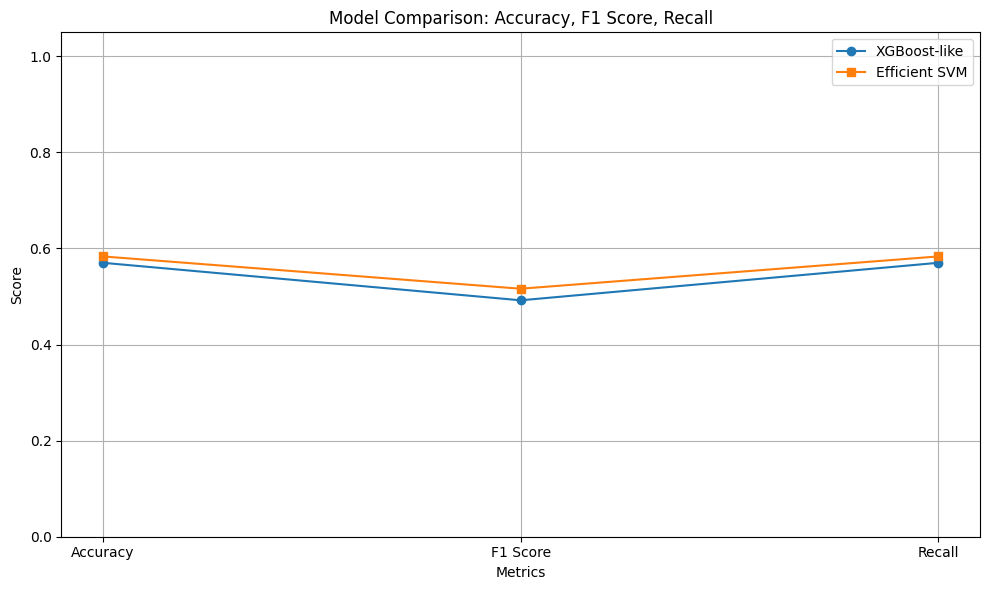

In [ ]:
import matplotlib.pyplot as plt

# Example values - replace these with actual computed metrics
metrics = ['Accuracy', 'F1 Score', 'Recall']

# Replace these with your actual metrics
xgb_metrics = [accuracy, f1, recall]  # From your XGBoost-like model
svm_metrics = [
    accuracy_score(y_test, svm.predict(X_test_scaled)),
    f1_score(y_test, svm.predict(X_test_scaled), average='weighted'),
    recall_score(y_test, svm.predict(X_test_scaled), average='weighted')
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(metrics, xgb_metrics, marker='o', label='XGBoost-like')
plt.plot(metrics, svm_metrics, marker='s', label='Efficient SVM')
plt.title("Model Comparison: Accuracy, F1 Score, Recall")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    print(f"\n{dataset_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall:   {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# 📌 Evaluate on training set
y_train_pred = model.predict(X_train_scaled)
evaluate_model(y_train, y_train_pred, dataset_name="Training Set")

# 📌 Evaluate on test set (only if labels are available)
if y_test is not None:
    y_test_pred = model.predict(X_test_scaled)
    evaluate_model(y_test, y_test_pred, dataset_name="Test Set")
else:
    print("No ground truth labels found in test set.")



Training Set Evaluation:
Accuracy: 0.8990
Recall:   0.8990
F1 Score: 0.8993

Test Set Evaluation:
Accuracy: 0.6065
Recall:   0.6065
F1 Score: 0.5559


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm  # For progress bar
import pickle

# Define a more efficient SVM implementation
class SVM_Efficient:
    def __init__(self, learning_rate=0.02, lambda_param=0.005, n_iters=500, batch_size=32):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.w = None
        self.b = None

    def fit(self, X, y):
        # Convert y values to -1 and 1 (SVM convention)
        y_ = np.where(y <= 0, -1, 1)

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        # Use mini-batch gradient descent for efficiency
        print("Training SVM model efficiently...")
        for _ in tqdm(range(self.n_iters)):
            # Create random batch indices
            batch_indices = np.random.choice(n_samples, min(self.batch_size, n_samples), replace=False)
            X_batch = X[batch_indices]
            y_batch = y_[batch_indices]

            # Compute gradients on batch
            for idx, x_i in enumerate(X_batch):
                condition = y_batch[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_batch[idx]))
                    self.b -= self.lr * y_batch[idx]

            # Decrease learning rate slightly each iteration (learning rate decay)
            self.lr = self.lr * 0.99

    def predict(self, X):
        # Calculate decision function
        decision_function = np.dot(X, self.w) - self.b

        # Convert to binary predictions (0 or 1)
        return np.where(decision_function <= 0, 0, 1)

# Load the train and test datasets
print("Loading datasets...")
train_df = pd.read_csv('/content/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('/content/customer_churn_dataset-testing-master.csv')

# Handle missing values in training data
train_df = train_df.dropna()
print(f"Training data shape after removing missing values: {train_df.shape}")

# Ensure column names match between datasets
# Rename columns based on test dataset format
print("Aligning column names...")
column_mapping = {
    'CustomerID': 'CustomerID',
    'Age': 'Age',
    'Gender': 'Gender',
    'Tenure': 'Tenure',
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction',
    'Churn': 'Churn'
}

# Apply renaming to both datasets to ensure consistency
train_df = train_df.rename(columns=column_mapping)
test_df = test_df.rename(columns={
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction'
})

# Preprocess the data
print("Preprocessing data...")
# Encode categorical features
categorical_cols = ['Gender', 'Subscription', 'Contract_Length']
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Ensure test has same columns as train
train_feature_columns = [col for col in train_encoded.columns if col != 'Churn']
for col in train_feature_columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0

# Make sure test only has columns that are in train (excluding Churn)
test_columns_to_use = [col for col in test_encoded.columns if col in train_feature_columns or col == 'Churn']
test_encoded = test_encoded[test_columns_to_use]

# Drop the customer ID column
train_encoded = train_encoded.drop('CustomerID', axis=1)
test_encoded = test_encoded.drop('CustomerID', axis=1)

# Define features and target for train
X_train = train_encoded.drop('Churn', axis=1)
y_train = train_encoded['Churn']

# Define features for test (and target if available)
if 'Churn' in test_encoded.columns:
    X_test = test_encoded.drop('Churn', axis=1)
    y_test = test_encoded['Churn']
else:
    X_test = test_encoded
    y_test = None
    print("\nNote: Test dataset does not contain 'Churn' label column. Only predictions will be provided.")

# Print shapes to verify
print(f"\nTraining features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
if y_test is not None:
    print(f"Testing target shape: {y_test.shape}")

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Save the scaler
scaler_filename = 'scaler.pkl'
print(f"Saving the scaler to {scaler_filename}...")
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print("Scaler saved successfully!")

# Train SVM model with more efficient hyperparameters
svm = SVM_Efficient(learning_rate=0.02, lambda_param=0.005, n_iters=500, batch_size=32)
svm.fit(X_train_scaled, y_train)
print("Training complete!")
# Save the trained SVM model to a file
model_filename = 'svm_efficient_model.pkl'
print(f"Saving the trained model to {model_filename}...")
with open(model_filename, 'wb') as file:
    pickle.dump(svm, file)
print("Model saved successfully!")

# Make predictions
print("Making predictions...")
y_train_pred = svm.predict(X_train_scaled)
y_test_pred = svm.predict(X_test_scaled)

# Evaluate on training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("\nTraining Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Evaluate on test set if labels are available
if y_test is not None:
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print("\nTest Set Evaluation:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Create a confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Print classification report for more detailed metrics
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
else:
    # Save predictions to CSV if test labels are not available
    test_df['Predicted_Churn'] = y_test_pred
    test_df.to_csv('test_predictions.csv', index=False)
    print("\nPredictions saved to 'test_predictions.csv'")

# Feature importance visualization
feature_names = X_train.columns
feature_importance = abs(svm.w)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), np.array(feature_names)[sorted_idx], rotation=90)
plt.title('Feature Importance Based on SVM Weights')
plt.tight_layout()
plt.show()

# Create a confusion matrix for training set
train_cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Training Set)')
plt.show()

# Compare churn vs non-churn customer profiles
numerical_cols = ['Age', 'Tenure', 'Usage_Frequency', 'Support_Calls',
                  'Payment_Delays', 'Total_Spend', 'Last_Interaction']

churn_customers = train_df[train_df['Churn'] == 1.0]
non_churn_customers = train_df[train_df['Churn'] == 0.0]

# Create profile comparison
profile_comparison = pd.DataFrame({
    'Churn_Mean': churn_customers[numerical_cols].mean(),
    'Non_Churn_Mean': non_churn_customers[numerical_cols].mean(),
    'Difference': churn_customers[numerical_cols].mean() - non_churn_customers[numerical_cols].mean()
})

print("\nCustomer Profile Comparison (Churn vs. Non-Churn):")
print(profile_comparison)

# Visualize differences
plt.figure(figsize=(12, 6))
profile_comparison['Difference'].plot(kind='bar')
plt.title('Difference in Features Between Churned and Non-Churned Customers')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

In [ ]:
# 📌 STEP 7: Predict Churn for Custom Input

def get_user_input():
    print("\n--- Enter Customer Details to Predict Churn ---")
    age = float(input("Age: "))
    gender = input("Gender (Male/Female): ").strip()
    tenure = int(input("Tenure (in months): "))
    usage_frequency = float(input("Usage Frequency: "))
    support_calls = int(input("Number of Support Calls: "))
    payment_delays = int(input("Payment Delays: "))
    subscription = input("Subscription Type (Basic/Premium/Gold): ").strip()
    contract_length = input("Contract Length (Monthly/Yearly): ").strip()
    total_spend = float(input("Total Spend: "))
    last_interaction = float(input("Last Interaction (days ago): "))

    user_dict = {
        'Age': age,
        'Tenure': tenure,
        'Usage_Frequency': usage_frequency,
        'Support_Calls': support_calls,
        'Payment_Delays': payment_delays,
        'Total_Spend': total_spend,
        'Last_Interaction': last_interaction,
        'Gender_Male': 1 if gender.lower() == 'male' else 0,
        'Subscription_Premium': 1 if subscription.lower() == 'premium' else 0,
        'Subscription_Gold': 1 if subscription.lower() == 'gold' else 0,
        'Contract_Length_Yearly': 1 if contract_length.lower() == 'yearly' else 0
    }

    return pd.DataFrame([user_dict])

# Get user input
user_input_df = get_user_input()

# Ensure all training features are present
for col in X_train.columns:
    if col not in user_input_df.columns:
        user_input_df[col] = 0  # default to 0 for missing features

# Align column order
user_input_df = user_input_df[X_train.columns]

# Scale input
user_input_scaled = scaler.transform(user_input_df)

# Predict churn
prediction = model.predict(user_input_scaled)[0]
prob = model.predict_proba(user_input_scaled)[0]

# Show result
print("\n🔍 Prediction:")
print("⚠️ Customer is likely to churn!" if prediction == 1 else "✅ Customer is likely to stay.")
print(f"Confidence of Churn: {prob:.2%}")



--- Enter Customer Details to Predict Churn ---
Age: 19
Gender (Male/Female): Female
Tenure (in months): 9
Usage Frequency: 9
Number of Support Calls: 9
Payment Delays: 1
Subscription Type (Basic/Premium/Gold): Gold
Contract Length (Monthly/Yearly): Yearly
Total Spend: 7
Last Interaction (days ago): 1

🔍 Prediction:
⚠️ Customer is likely to churn!
Confidence of Churn: 58.42%


In [ ]:
# 📌 STEP 1: Install XGBoost (Only needed once)
!pip install xgboost --quiet

# 📌 STEP 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# 📌 STEP 3: Load and Preprocess Data
print("Loading data...")
train_df = pd.read_csv('/content/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('/content/customer_churn_dataset-testing-master.csv')
train_df = train_df.dropna()

# Rename columns for consistency
column_mapping = {
    'CustomerID': 'CustomerID',
    'Age': 'Age',
    'Gender': 'Gender',
    'Tenure': 'Tenure',
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction',
    'Churn': 'Churn'
}
train_df = train_df.rename(columns=column_mapping)
test_df = test_df.rename(columns={
    'Usage Frequency': 'Usage_Frequency',
    'Support Calls': 'Support_Calls',
    'Payment Delay': 'Payment_Delays',
    'Subscription Type': 'Subscription',
    'Contract Length': 'Contract_Length',
    'Total Spend': 'Total_Spend',
    'Last Interaction': 'Last_Interaction'
})

# One-hot encode categorical features
categorical_cols = ['Gender', 'Subscription', 'Contract_Length']
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align columns in test with train
for col in train_encoded.columns:
    if col not in test_encoded.columns and col != 'Churn':
        test_encoded[col] = 0

# Drop CustomerID
if 'CustomerID' in train_encoded.columns:
    train_encoded = train_encoded.drop(columns='CustomerID')
if 'CustomerID' in test_encoded.columns:
    test_encoded = test_encoded.drop(columns='CustomerID')

# Define features and labels
X_train = train_encoded.drop(columns='Churn')
y_train = train_encoded['Churn']
X_test = test_encoded.drop(columns='Churn', errors='ignore')
y_test = test_encoded['Churn'] if 'Churn' in test_encoded.columns else None

# 📌 STEP 4: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📌 STEP 5: Train XGBoost
print("Training XGBoost model...")
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 📌 STEP 6: Evaluate (if y_test available)
if y_test is not None:
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    print(f"\n✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Recall:   {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
else:
    print("No ground truth labels found in test set.")
